# Topological regularization of circle embedding

In this notebook, we show how a topological loss can be combined with a linear embedding procedure, as to regularize the embedding and better reflect the topological---in this case circular---prior. 

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Pytorch compatible topology layer and losses
import torch
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss, pca_loss, ortho_loss

# Ordinary and topologically regularized PCA embedding
from Code.topembed import PCA

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Quantitative evaluation
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from Code.evaluation import evaluate_embeddings

# Representative cycle analysis with alpha-filtrations
import networkx as nx
import diode
import dionysus

%matplotlib inline

## Construct data and view restriction to first two coordinates

We now construct a high-dimensional data set sampled from a circular model. The model occurs only in the first two dimensions, and the high-dimensionality of the data is directly caused by random noise.

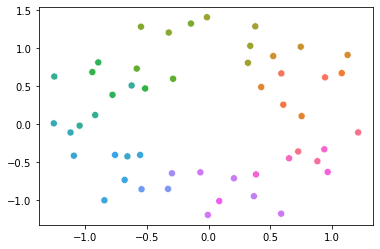

In [2]:
# Seed for reproducibility
np.random.seed(420)

# Sample parameters
npoints = 50 # number of points
ndim = 500 # data dimensionality (with noise)
sigma = 0.45 # magnitude of noise per dimension

# Sample data
t = np.random.uniform(low=0, high=2 * np.pi, size=npoints)
X = np.concatenate([np.transpose(np.array([np.cos(t), np.sin(t)])), np.zeros([npoints, ndim - 2])], axis=1)
N = np.random.uniform(low=-sigma, high=sigma, size=[npoints, ndim])
data = X + N

# Plot the first two dimensions of the data two illustrate the circular model
fig, ax = plt.subplots()
sns.scatterplot(x=data[:,0], y=data[:,1], s=50, hue=t, palette="husl", ax=ax)
ax.get_legend().remove()
plt.show()

## Conduct ordinary PCA embedding

We now explore how well the ordinary PCA embedding is able to recover the model from our data.

Time for embedding: 00:00:00


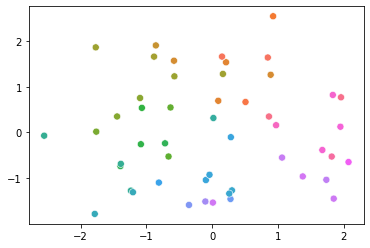

In [3]:
# Conduct PCA embedding
Y_pca, W_pca = PCA(data, random_state=42)

# View PCA embedding (flip for consistency)
fig, ax = plt.subplots()
sns.scatterplot(x=-Y_pca[:,0], y=Y_pca[:,1], s=50, hue=t, palette="husl", ax=ax)
ax.get_legend().remove()
plt.show()

We see that due to the noise in high dimensions, while the overall ordering points is good, PCA is no longer able to effectively recover the circular hole.

## Apply topological regularization to the embedding

We now show how we can bias a linear embedding using a loss function that captures our topological prior.

The model we will use for this learns a linear transformation $W$, which is optimized for the following three losses:
- the reconstruction loss between our data and its $X$ low-rank approximation $XWW^T$;
- a loss function encouraging orthonormality of $W$, i.e., such that  $WW^T$ is a projection matrix;
- a loss function that captures our topological prior.

As a topological loss, we will use the persistence of the most prominent cycle in our embedding. It is important to multiply this by a factor $\lambda_{\mathrm{top}} <0$, since we want this persistence to be high. To obtain this loss, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

In [4]:
# Define topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=1) # alpha complex layer
CircularPersistence = DiagramLoss(dim=1, j=1, g=g) # compute persistence of most prominent cycle
lambda_top = -1e1 # scalar factor that trades off embedding and topological loss

# Construct topological loss function
def top_loss(output):
    dgminfo = TopLayer(output)
    loss = lambda_top * CircularPersistence(dgminfo)
    
    return loss

We can now conduct the topologically regularized linear embedding as follows.

[epoch 1] [emb. loss: 0.063185, ortho. loss: 0.001478, top. loss: -1.539055, total loss: -1.474392]
[epoch 50] [emb. loss: 0.067497, ortho. loss: 3410.821045, top. loss: -0.782473, total loss: 3410.105957]
[epoch 100] [emb. loss: 0.066744, ortho. loss: 1016.062500, top. loss: -3.505133, total loss: 1012.624146]
[epoch 150] [emb. loss: 0.066747, ortho. loss: 1201.616699, top. loss: -5.466840, total loss: 1196.216675]
[epoch 200] [emb. loss: 0.066591, ortho. loss: 555.281982, top. loss: -8.052293, total loss: 547.296265]
[epoch 250] [emb. loss: 0.067223, ortho. loss: 6603.874023, top. loss: -2.147141, total loss: 6601.794434]
[epoch 300] [emb. loss: 0.066911, ortho. loss: 1616.312256, top. loss: -5.034025, total loss: 1611.345093]
[epoch 350] [emb. loss: 0.066875, ortho. loss: 1885.948242, top. loss: -3.005395, total loss: 1883.009766]
[epoch 400] [emb. loss: 0.066544, ortho. loss: 377.594055, top. loss: -7.798023, total loss: 369.862579]
[epoch 450] [emb. loss: 0.066521, ortho. loss: 31

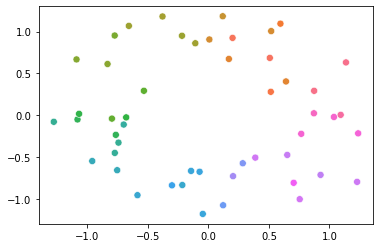

In [5]:
# Learning hyperparameters
num_epochs = 500
learning_rate = 1e-1

# Conduct topological regularization
Y_top, W_top, losses_top = PCA(data, top_loss=top_loss, num_epochs=num_epochs, 
                               learning_rate=learning_rate, random_state=42)

# View topologically regularized embedding (flip for consistency)
fig, ax = plt.subplots()
sns.scatterplot(x=Y_top[:,0], y=-Y_top[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

## Compare with ordinary topological optimization

For comparison, we also conduct the same topological optimization procedure directly on the initialized embedding.
We observe that the results were much worse than when we accounted for the embedding loss.

[epoch 1] [emb. loss: 0.000000, ortho. loss: 0.001478, top. loss: -1.539055, total loss: -1.537577]
[epoch 50] [emb. loss: 0.000000, ortho. loss: 3397.123535, top. loss: -0.791807, total loss: 3396.331787]
[epoch 100] [emb. loss: 0.000000, ortho. loss: 543.927490, top. loss: -6.307951, total loss: 537.619568]
[epoch 150] [emb. loss: 0.000000, ortho. loss: 1442.463501, top. loss: -3.729107, total loss: 1438.734375]
[epoch 200] [emb. loss: 0.000000, ortho. loss: 1797.159668, top. loss: -5.906724, total loss: 1791.252930]
[epoch 250] [emb. loss: 0.000000, ortho. loss: 1037.598145, top. loss: -6.311464, total loss: 1031.286621]
[epoch 300] [emb. loss: 0.000000, ortho. loss: 1997.365601, top. loss: -3.227956, total loss: 1994.137695]
[epoch 350] [emb. loss: 0.000000, ortho. loss: 3691.520752, top. loss: -3.611770, total loss: 3687.908936]
[epoch 400] [emb. loss: 0.000000, ortho. loss: 1454.978638, top. loss: -7.833032, total loss: 1447.145630]
[epoch 450] [emb. loss: 0.000000, ortho. loss: 

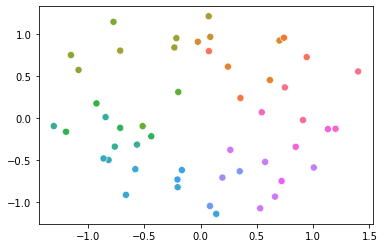

In [6]:
# Learning hyperparameters
num_epochs = 500
learning_rate = 1e-1

# Conduct topological optimization
Y_opt, W_opt, losses_opt = PCA(data, 2, emb_loss=False, top_loss=top_loss, num_epochs=num_epochs, 
                               learning_rate=learning_rate, random_state=42)

# View topologically optimized embedding (flip for consistency)
fig, ax = plt.subplots()
sns.scatterplot(x=Y_opt[:,0], y=-Y_opt[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

We observe that the results are highly similar.

## Quantitative evaluation

First, we evaluate the different losses (embedding and topological) for all final embeddings.

In [7]:
print("\033[1mLosses for pca embedding: \033[0m")
print("Reconstruction: " + str(losses_top["embedding"][0])) # PCA initialization gives first embedding loss
print("Orthonormality: " + str(ortho_loss(torch.tensor(W_pca)).item()))
print("Topological: " + str(top_loss(torch.tensor(Y_pca).type(torch.float)).item() / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically optimized pca embedding: \033[0m")
print("Reconstruction: " + str(pca_loss(torch.tensor(data - data.mean(axis=0)), 
                                        torch.tensor(W_opt), torch.tensor(Y_opt)).item()))
print("Orthonormality: " + str(ortho_loss(torch.tensor(W_opt)).item()))
print("Topological: " + str(top_loss(torch.tensor(Y_opt).type(torch.float)).item() / np.abs(lambda_top)) + "\n")

print("\033[1mLosses for topologically regularized pca embedding: \033[0m")
print("Reconstruction: " + str(pca_loss(torch.tensor(data - data.mean(axis=0)), 
                                        torch.tensor(W_top), torch.tensor(Y_top)).item()))
print("Orthonormality: " + str(ortho_loss(torch.tensor(W_top)).item()))
print("Topological: " + str(top_loss(torch.tensor(Y_top).type(torch.float)).item() / np.abs(lambda_top)))

Losses for pca embedding: 
Reconstruction: 0.06318476796150208
Orthonormality: 1.7184031883525453e-15
Topological: -0.15390551090240479

Losses for topologically optimized pca embedding: 
Reconstruction: 0.06680672810017917
Orthonormality: 0.21647799015045166
Topological: -0.34679036140441893

Losses for topologically regularized pca embedding: 
Reconstruction: 0.06649286039989714
Orthonormality: 0.028079602867364883
Topological: -0.7508018016815186


We also compare the magnitudes of the new projection weights with those from the ordinary PCA embedding.

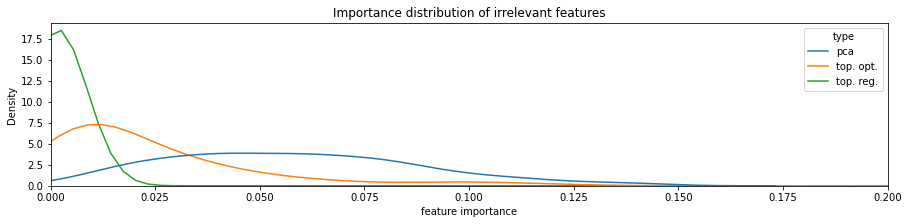

In [8]:
# Compute the magnitudes of the weights by dimension
magnitudes = pd.DataFrame(np.array([np.sum(np.abs(W[2:,:]), axis=1) for W in [W_pca, W_opt, W_top]]).ravel(),
                         columns=["magnitude"])
magnitudes["type"] = (data.shape[1] - 2) * ["pca"] + (data.shape[1] - 2) * ["top. opt."] + \
                        (data.shape[1] - 2) * ["top. reg."]
    
# Compare the magnitudes
fig, ax = plt.subplots(figsize=(15, 3))
sns.kdeplot(data=magnitudes, x="magnitude", hue="type", ax=ax)
ax.set_xlim(0, 0.2)
ax.set_title("Importance distribution of irrelevant features")
ax.set_xlabel("feature importance")
plt.show()

We see that by adding a loss for topological regularization, the linear embedding model puts less emphasis on the majority of features that are irrelevant for capturing the topological prior.

Finally, we compare if the topologically regularized embedding improves on the ordinary PCA embedding for predicting data point labels.

In [9]:
# Machine learning model to be used for label prediction
Ys = {"pca": Y_pca, "top. opt.": Y_opt, "top. reg.": Y_top}
model = MultiOutputRegressor(SVR())
scoring = "r2"

# Hyperparameters for quantitative evaluation
ntimes = 100
test_frac = 0.1
params = {"estimator__C":[0.01, 0.1, 1, 10, 100]}

# Obtain performances over multiple train-test splits
performances = evaluate_embeddings(Ys, X[:,:2], model, scoring, params=params, ntimes=ntimes, 
                                   test_frac=test_frac, random_state=42)

# View resulting performances
pd.concat([pd.DataFrame({"mean":performances.mean(axis=0)}),
           pd.DataFrame({"std":performances.std(axis=0)})], axis=1)\
            .style.highlight_max(subset="mean", color="lightgreen", axis=0)

,mean,std
pca,0.562144,0.472218
top. opt.,0.774822,0.244247
top. reg.,0.849050,0.137003


## Topological regularization for different shape prior
Finally, we study how the tologically regularized embedding varies over different forms of (potentially wrong) prior topological information. In particular, we study the topologically regularized embedding when the topological loss function is designed to ensure that:

1) The sum of persistence of the two most prominent cycles is high.<br>
2) The persistence of the second most prominent cycle is high.<br>
3) The topology resembles a connected component with at least three flares away from the center.

All other hyperparameters will be kept equal.

In [10]:
# Define different topological loss
def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
TopLayer = AlphaLayer(maxdim=1) # alpha complex layer
CircularPersistence = DiagramLoss(dim=1, j=1, g=g) # compute persistence of most prominent cycle
CircularPersistence2 = DiagramLoss(dim=1, i=2, j=2, g=g) # sum of persistence of two most prominent cycles
CircularPersistence2Total = DiagramLoss(dim=1, i=1, j=2, g=g) # sum of persistence of two most prominent cycles
ComponentPersistence = DiagramLoss(dim=0, i=2, g=g) # compute total (finite) persistence
Component3Persistence = DiagramLoss(dim=0, i=3, j=3, g=g) # compute persistence of third most prominent gap
lambda_top = -1e1 # scalar factor that trades off embedding and topological loss
tau_flare = 0.25 # sample fraction for which the flare topological loss is computed

# Construct the topological loss functions
def top_loss_other1(output):
    dgminfo = TopLayer(output)
    loss = lambda_top * CircularPersistence2Total(dgminfo)
    
    return loss

def top_loss_other2(output):
    dgminfo = TopLayer(output)
    loss = lambda_top * CircularPersistence2(dgminfo)
    
    return loss

def top_loss_other3(output):    
    # Loss for connectedness
    dgminfo_connected = TopLayer(output)         
    loss_connected = ComponentPersistence(dgminfo_connected)

    # Loss for flare
    f = torch.norm(output - torch.mean(output, dim=0), dim=1)
    f /= torch.max(f)
    dgminfo_flare = TopLayer(output[f > tau_flare,:])
    loss_flare = -Component3Persistence(dgminfo_flare)    
        
    # Total loss
    loss = -lambda_top * (loss_connected + loss_flare)
    
    return loss

We now obtain the topologically regularized embeddings for the different loss functions.

Conducting topologically regularized embedding for topological loss 1
[epoch 1] [emb. loss: 0.063185, ortho. loss: 0.001478, top. loss: -3.069539, total loss: -3.004876]
[epoch 50] [emb. loss: 0.067590, ortho. loss: 4030.990967, top. loss: -1.291014, total loss: 4029.767578]
[epoch 100] [emb. loss: 0.066726, ortho. loss: 678.191345, top. loss: -8.951507, total loss: 669.306580]
[epoch 150] [emb. loss: 0.066657, ortho. loss: 784.648376, top. loss: -10.140961, total loss: 774.574097]
[epoch 200] [emb. loss: 0.066653, ortho. loss: 1258.971802, top. loss: -7.716102, total loss: 1251.322388]
[epoch 250] [emb. loss: 0.066619, ortho. loss: 548.612061, top. loss: -5.368172, total loss: 543.310486]
[epoch 300] [emb. loss: 0.066566, ortho. loss: 355.967926, top. loss: -7.132659, total loss: 348.901825]
[epoch 350] [emb. loss: 0.067129, ortho. loss: 3932.833740, top. loss: -3.193539, total loss: 3929.707275]
[epoch 400] [emb. loss: 0.067130, ortho. loss: 4167.404297, top. loss: -4.837134, total l

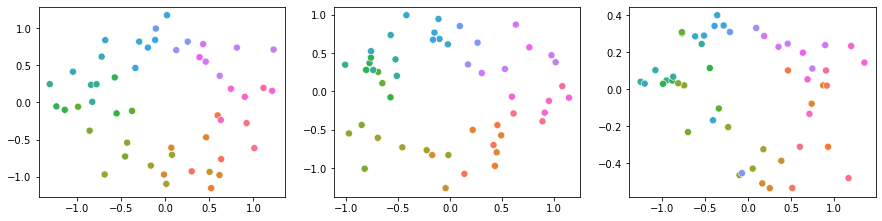

In [12]:
# Learning hyperparameters
num_epochs = 500
learning_rate = 1e-1

# Conduct topological regularization for different topological loss functions
top_losses = [top_loss_other1, top_loss_other2, top_loss_other3]
Y_tops = []

for idx, this_top_loss in enumerate(top_losses):
    # Conduct topological regularization
    print("\033[1mConducting topologically regularized embedding for topological loss " + str(idx + 1) + "\033[0m")
    this_Y_top, W_top, losses_top = PCA(data, top_loss=this_top_loss, num_epochs=num_epochs,
                                        learning_rate=learning_rate, random_state=42)
    Y_tops.append(this_Y_top)
    print("\n")
    
# View topologically regularized embeddings
fig, ax = plt.subplots(1, len(top_losses), figsize=(len(top_losses) * 5, 3.5))
for idx in range(len(top_losses)):
    sns.scatterplot(x=Y_tops[idx][:,0], y=Y_tops[idx][:,1], s=50, hue=t, palette="husl", ax=ax[idx])
    ax[idx].get_legend().remove()
plt.show()